In [1]:
from util import *
import seaborn as sns


# Example Notebook

This notebook shows how to load in a cleaned dataset with various features and target variables.

In [2]:
# Change to directory of dataset file
# Dataset file is guaranteed to have all days for all stocks, i.e. shift(30) is guaranteed to be 30 calendar days
# This leaves a lot of NaNs to be filled
path = "~/s3local/sentimentgroup/datasets/roberta.parquet"

In [3]:
# Horizons to calculate future returns (e.g. price after N days)
target_horizons = [10, 30, 90]
# Horizons to calculate lookbacks for rolling means (e.g. mean sentiment over last N days)
lookback_periods = [10, 30, 90]
# Enable to add residualised returns as a target 
# Also known as idiosyncratic returns, ie individual stock returns after removing overall market trends 
# Takes about 60 seconds per target horizon, so disable if not needed
residualise_returns = False

# Date range, leave None to use all available data (where we have prices)
start_date = "2014-01-01"
end_date = "2022-01-01" # Keep out of sample for now
df = load_dataset(
    path,
    target_horizons = target_horizons,
    lookback_periods = lookback_periods,
    residualise_returns = residualise_returns,
    start_date=start_date,
    end_date=end_date
)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


*Notebook to analyse basic correlations between signals and target returns.*

We are trying to see which input features have the strongest predictive effect in sample (pre 2022) and use those correlations to inform a basic trading strategy.

In [4]:

def plot_feature_target_correlation(df, exclude=[]):
    # Select target and feature columns
    target_cols = [col for col in df.columns if col.startswith('tgt_')]
    feature_cols = [col for col in df.columns if col.startswith('ft_') and col not in exclude]
    
    # Compute correlation matrix
    corr_matrix = df[feature_cols + target_cols].corr()
    
    # Extract only feature vs. target correlations
    corr_submatrix = corr_matrix.loc[feature_cols, target_cols]
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_submatrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Feature vs Target Correlation Matrix")
    plt.xlabel("Targets")
    plt.ylabel("Features")
    plt.show()

In [5]:
df["ft_past_returns_30"] = df.groupby("symbol")["close"].pct_change(30).reset_index(0, drop=True)
df['ft_close'] = df.close

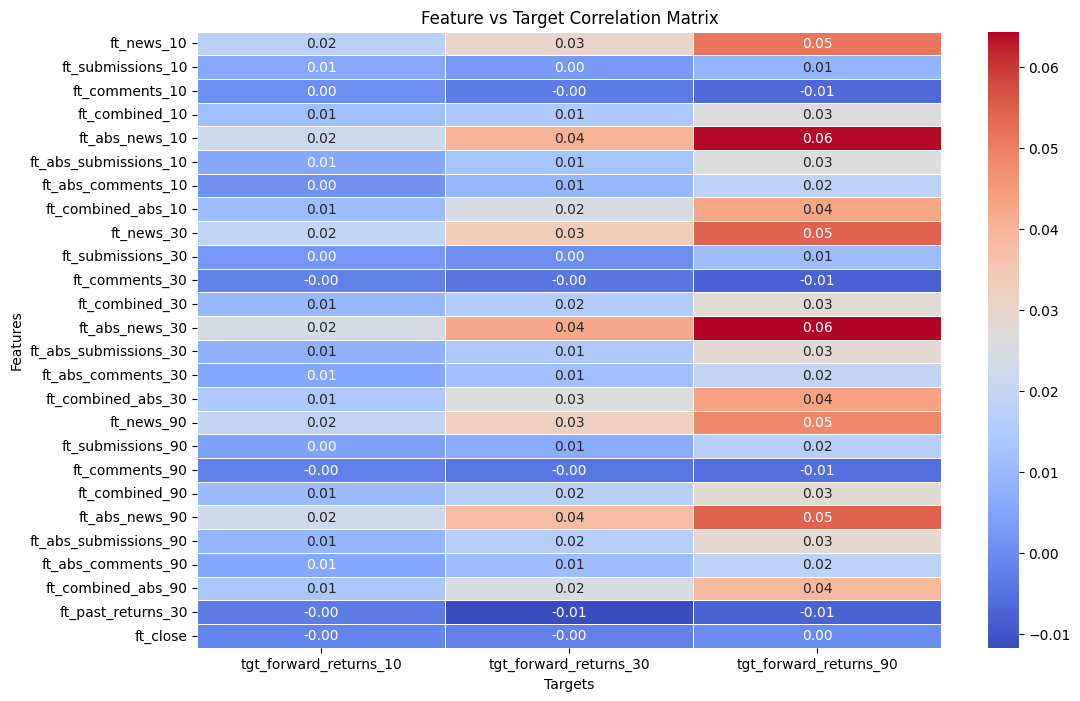

In [6]:
plot_feature_target_correlation(df, exclude=["ft_news", "ft_submissions", "ft_comments", "ft_combined", "ft_abs_news", "ft_abs_submissions", "ft_abs_comments", "ft_combined_abs"])

Notes:
- Stronger correlation at larger horizons.
- Stronger correlation on the abs(sentiment) features than actual sentiment. 
- No correlation on regular positive/negative reddit features, likely due to hard to interpret (swearing, etc)
- No correlation on past returns/close price, hopefully shows theres not some inherent bias with the data

In [47]:
# Helper function for Cumsum(target) vs Feature plot (also in util.py)
def csvf_plot(df, ft, tgt):
    cs = df.sort_values(ft)
    cs["cs_ret"] = cs[tgt].cumsum()
    cs["cs_trades"] = 1
    cs["cs_trades"] = cs.cs_trades.cumsum()
    ax = cs.plot(x=ft, y="cs_ret")
    cs.plot(x=ft, y="cs_trades", ax=ax.twinx(), style='r--')

Here are some example csvf plots to show the usage

Forward returns (10 day) vs mean submission sentiment in last 10 days.
If there were no correlation at all, the blue line would lie exactly on top of the red dotted line.
In the bottom left we can see (-0.4 to -0.2) that the target cumsum is below cs_trades - this shows that the average returns at lower sentiment were smaller, and at the top right (sentiment 0.1 to 0.2) we see that the blue line crossed above the red line, indicating that returns there were larger.

Csvf plots aren't super sciencey, think of it as a sum of returns (i.e pnl) vs our feature. If we can find regions in the X axis where pnl goes up a lot, we should buy, if it goes down a lot, we want to sell. The fact these two lines are very similar shows how small correlations are, this isn't discouraging, if we could see huge differences it would suggest something was wrong.

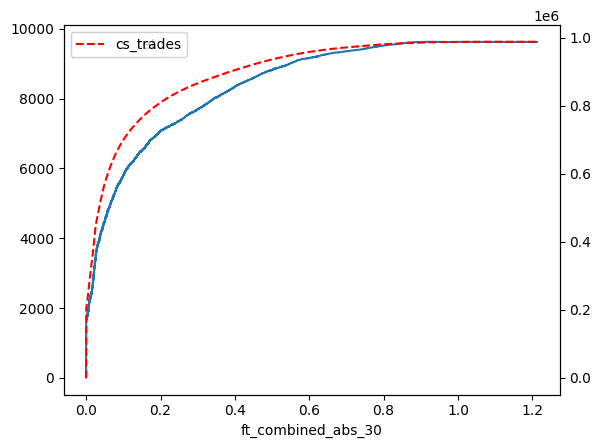

In [7]:
csvf_plot(df[df.ft_combined_abs_90 != 0], "ft_combined_abs_30", "tgt_forward_returns_30")

In [8]:
import pandas as pd
import numpy as np


def simulate_portfolio_vectorized(df, initial_capital=10000.0, tc_rate=0.001):
    """
    Simulate a trading portfolio with capital allocation based on signal values using
    NumPy vectorization for improved performance.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: 'dt' (date), 'close', 'symbol', 'signal'
    initial_capital : float, default 10000.0
        Initial capital to start with
    tc_rate : float, default 0.001
        Transaction cost rate (e.g., 0.001 = 0.1%)
    
    Returns:
    --------
    portfolio_df : pandas.DataFrame
        DataFrame with portfolio performance metrics
    """
    # Convert input dataframe to a pivot table format for vectorized operations
    # This creates a multi-indexed DataFrame with dates as index and symbols as columns
    pivot_close = df.pivot_table(index='dt', columns='symbol', values='close')
    pivot_signal = df.pivot_table(index='dt', columns='symbol', values='signal')
    
    # Fill NaN with 0 for signals (no signal = no allocation)
    pivot_signal = pivot_signal.fillna(0)
    
    # Get unique dates and symbols
    dates = pivot_close.index.unique()
    symbols = pivot_close.columns.unique()
    n_dates = len(dates)
    n_symbols = len(symbols)
    
    # Initialize arrays to store results
    portfolio_values = np.zeros(n_dates)
    cash_values = np.zeros(n_dates)
    position_values = np.zeros(n_dates)
    transaction_costs = np.zeros(n_dates)
    positions_array = np.zeros((n_dates, n_symbols))
    
    # Initial cash
    cash_values[0] = initial_capital
    portfolio_values[0] = initial_capital
    
    # Process each date (starting from the second date)
    for t in range(1, n_dates):
        prev_date = dates[t-1]
        curr_date = dates[t]
        
        # Get prices and signals for current date
        curr_prices = pivot_close.loc[curr_date].values
        curr_signals = pivot_signal.loc[curr_date].values
        
        # Replace NaN prices with previous day's prices or zeros
        prev_prices = pivot_close.loc[prev_date].values
        mask_curr_nan = np.isnan(curr_prices)
        curr_prices[mask_curr_nan] = prev_prices[mask_curr_nan]
        curr_prices[np.isnan(curr_prices)] = 0
        
        # Get previous positions
        prev_positions = positions_array[t-1]
        
        # Current position values before rebalancing
        prev_position_values = prev_positions * curr_prices
        prev_portfolio_value = cash_values[t-1] + np.sum(prev_position_values)
        
        # Calculate total signal and allocation ratios
        total_signal = np.sum(curr_signals)
        
        if total_signal > 0:
            # Calculate target positions based on signal allocation
            allocation_ratios = curr_signals / total_signal
            target_values = prev_portfolio_value * allocation_ratios
            target_positions = np.zeros_like(target_values)
            
            # Avoid division by zero
            mask_valid_prices = curr_prices > 0
            target_positions[mask_valid_prices] = target_values[mask_valid_prices] / curr_prices[mask_valid_prices]
            
            # Calculate trades
            trades = target_positions - prev_positions
            trade_values = np.abs(trades) * curr_prices
            
            # Calculate transaction costs
            trade_costs = trade_values * tc_rate
            total_cost = np.sum(trade_costs)
            
            # Process buys (positive trades)
            buy_mask = trades > 0
            buy_values = trade_values[buy_mask]
            buy_costs = trade_costs[buy_mask]
            total_buy_cost = np.sum(buy_values) + np.sum(buy_costs)
            
            # Check if we have enough cash
            if total_buy_cost <= cash_values[t-1]:
                # Execute all trades
                new_positions = target_positions
                new_cash = cash_values[t-1] - np.sum(buy_values) - np.sum(buy_costs)
                
                # Add proceeds from sells
                sell_mask = trades < 0
                sell_values = trade_values[sell_mask]
                sell_costs = trade_costs[sell_mask]
                new_cash += np.sum(sell_values) - np.sum(sell_costs)
            else:
                # Not enough cash, scale down buys
                # This is a simplification; in reality, you might want to prioritize trades
                scale_factor = cash_values[t-1] / total_buy_cost if total_buy_cost > 0 else 0
                scaled_buys = trades.copy()
                scaled_buys[buy_mask] *= scale_factor
                
                # Execute scaled trades
                new_positions = prev_positions + scaled_buys
                
                # Calculate actual costs after scaling
                actual_buy_values = np.abs(scaled_buys[buy_mask]) * curr_prices[buy_mask]
                actual_buy_costs = actual_buy_values * tc_rate
                
                new_cash = cash_values[t-1] - np.sum(actual_buy_values) - np.sum(actual_buy_costs)
                
                # Process sells normally
                sell_mask = trades < 0
                sell_values = trade_values[sell_mask]
                sell_costs = trade_costs[sell_mask]
                new_cash += np.sum(sell_values) - np.sum(sell_costs)
                
                # Recalculate transaction costs
                total_cost = np.sum(actual_buy_costs) + np.sum(sell_costs)
        else:
            # No signals, keep positions the same
            new_positions = prev_positions
            new_cash = cash_values[t-1]
            total_cost = 0
        
        # Update state
        positions_array[t] = new_positions
        cash_values[t] = new_cash
        position_values[t] = np.sum(new_positions * curr_prices)
        portfolio_values[t] = cash_values[t] + position_values[t]
        transaction_costs[t] = total_cost
    
    # Create results DataFrame
    portfolio_df = pd.DataFrame({
        'date': dates,
        'portfolio_value': portfolio_values,
        'cash': cash_values,
        'positions_value': position_values,
        'transactions_cost': transaction_costs
    })
    
    # Add returns calculations
    portfolio_df['daily_return'] = (portfolio_df['portfolio_value'] / 
                                   portfolio_df['portfolio_value'].shift(1) - 1)
    portfolio_df['cumulative_return'] = (1 + portfolio_df['daily_return']).cumprod() - 1
    
    # Set date as index
    portfolio_df = portfolio_df.set_index('date')
    
    # Create positions DataFrame if needed
    positions_df = pd.DataFrame(positions_array, index=dates, columns=symbols)
    
    return portfolio_df, positions_df

In [20]:
df['signal'] = 1.0

In [29]:
port, pos = simulate_portfolio_vectorized(df, tc_rate=0)

In [61]:
df['signal'] = 1+0.5*df.ft_comments_90.pow(1)

In [63]:
port2, pos2 = simulate_portfolio_vectorized(df, tc_rate=0)

<Axes: xlabel='date'>

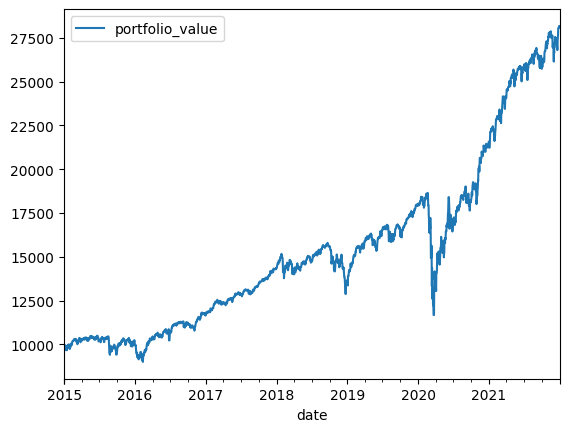

In [64]:
port2.reset_index().plot(x='date', y='portfolio_value')

<Axes: xlabel='dt'>

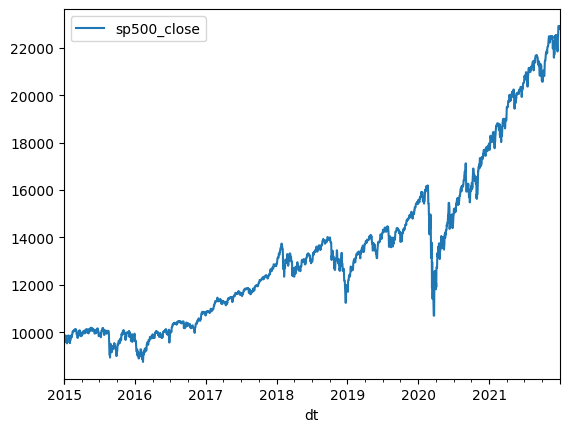

In [67]:
t = df[['dt', 'sp500_close']].drop_duplicates('dt').copy()
t['sp500_close'] *= 10000/ t.sp500_close.iloc[0]
t.plot(x='dt', y='sp500_close')

<Axes: xlabel='date'>

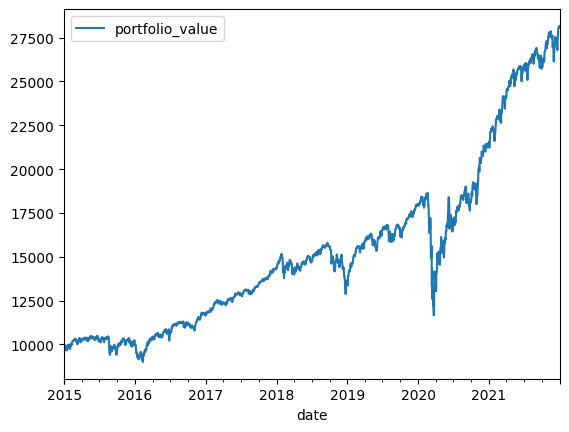

In [60]:
port.reset_index().plot(x='date', y='portfolio_value')

In [ ]:
p


,capital,holdings_value,total_value,daily_return,cumulative_return,peak,drawdown,annualized_return,annualized_volatility,sharpe_ratio
date,,,,,,,,,,
2014-12-29,2.842171e-14,1.000000e+05,100000.0,0.000000e+00,0.000000e+00,100000.0,0.000000e+00,-4.440892e-16,3.432516e-14,-0.012938
2014-12-30,9.953717e+04,4.628304e+02,100000.0,-3.330669e-16,-3.330669e-16,100000.0,-2.910383e-16,-4.440892e-16,3.432516e-14,-0.012938
2014-12-31,9.909343e+04,9.065694e+02,100000.0,1.554312e-15,1.110223e-15,100000.0,0.000000e+00,-4.440892e-16,3.432516e-14,-0.012938
2015-01-01,9.999273e+04,7.269146e+00,100000.0,-3.108624e-15,-1.998401e-15,100000.0,-3.055902e-15,-4.440892e-16,3.432516e-14,-0.012938
2015-01-02,1.000000e+05,2.842171e-14,100000.0,1.776357e-15,-2.220446e-16,100000.0,-1.309672e-15,-4.440892e-16,3.432516e-14,-0.012938
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.000000e+05,2.842171e-14,100000.0,0.000000e+00,-3.774758e-15,100000.0,-6.402843e-15,-4.440892e-16,3.432516e-14,-0.012938
2021-12-28,1.001287e+05,-1.287376e+02,100000.0,-2.886580e-15,-6.661338e-15,100000.0,-9.313226e-15,-4.440892e-16,3.432516e-14,-0.012938
2021-12-29,1.002941e+05,-2.941180e+02,100000.0,3.108624e-15,-3.552714e-15,100000.0,-6.111804e-15,-4.440892e-16,3.432516e-14,-0.012938
